### NEW CODE - loop over each discipline available

In [5]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

# Project root = parent directory of notebooks/
PROJECT_ROOT = Path().resolve().parent

# Data directories
DATA_RAW = PROJECT_ROOT / "data" / "raw"
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"


In [6]:
# Load the combined cleaned file generated by 01_cleaning.ipynb
df = pd.read_csv(DATA_PROCESSED / "all_events_results_clean.csv", parse_dates=["date"])

# Ensure time_seconds is numeric
df["time_seconds"] = pd.to_numeric(df["time_seconds"], errors="coerce")

# Drop obviously unusable rows
df = df.dropna(subset=["time_seconds", "sex", "date"])

df.head()


,event,sex,athlete,nationality,date,time_raw,time_seconds,wind,auto_raw
0,100m,men,Donald Lippincott,United States,1912-07-06,10.6,10.6,NaN,NaN
1,100m,men,Jackson Scholz,United States,1920-09-16,10.6,10.6,NaN,NaN
2,100m,men,Charley Paddock,United States,1921-04-23,10.4,10.4,NaN,NaN
3,100m,men,Eddie Tolan,United States,1929-08-08,10.4,10.4,0.0,NaN
4,100m,men,Eddie Tolan,United States,1929-08-25,10.4,10.4,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   event         154 non-null    object        
 1   sex           154 non-null    object        
 2   athlete       154 non-null    object        
 3   nationality   154 non-null    object        
 4   date          154 non-null    datetime64[ns]
 5   time_raw      154 non-null    object        
 6   time_seconds  154 non-null    float64       
 7   wind          97 non-null     float64       
 8   auto_raw      29 non-null     object        
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 11.0+ KB


: 

In [8]:
# Function to prepare yearly best times for a given event
def prepare_yearly_best(df_event: pd.DataFrame) -> pd.DataFrame:
    """
    For a given event dataframe (both sexes),
    compute yearly best (minimum) time for each sex.
    """
    tmp = df_event.copy()
    tmp["year"] = tmp["date"].dt.year
    yearly_best = (
        tmp.groupby(["sex", "year"])["time_seconds"]
           .min()
           .reset_index()
    )
    return yearly_best


In [9]:
# Plotting function
def plot_event_progression(df_all: pd.DataFrame, event_name: str, end_year: int = 2025):
    """
    Produce all plots for a given event:
    - yearly best progressions
    - LOESS smoothing
    - men–women gap (absolute and %), if both sexes present
    - regression slopes (yearly best and ffilled)
    """
    df_event = df_all[df_all["event"] == event_name].copy()
    if df_event.empty:
        print(f"No data for event '{event_name}', skipping.")
        return
    
    # Prepare yearly best
    yearly_best = prepare_yearly_best(df_event)
    
    # If less than 2 points, skip
    if yearly_best.empty:
        print(f"No valid yearly best data for '{event_name}', skipping.")
        return
    
    sexes_present = sorted(yearly_best["sex"].unique())
    print(f"\n===== Event: {event_name} | Sexes: {sexes_present} =====")
    
    # ---------- 1) Yearly best progression ----------
    plt.figure(figsize=(12, 6))
    for sex, group in yearly_best.groupby("sex"):
        plt.plot(group["year"], group["time_seconds"], marker="o", label=sex.capitalize())
    
    plt.title(f"Progression of {event_name} Performance: Men vs Women")
    plt.xlabel("Year")
    plt.ylabel("Best time (seconds)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # ---------- 2) LOESS smoothing ----------
    plt.figure(figsize=(12, 6))
    
    for sex, group in yearly_best.groupby("sex"):
        group = group.sort_values("year")
        
        # Raw points
        plt.scatter(group["year"], group["time_seconds"],
                    alpha=0.4, label=f"{sex.capitalize()} (raw)")
        
        # LOESS smoothing (only if enough points)
        if len(group) >= 5:
            smoothed = lowess(
                endog=group["time_seconds"],
                exog=group["year"],
                frac=0.3  # smoothing parameter
            )
            plt.plot(smoothed[:, 0], smoothed[:, 1],
                     linewidth=2, label=f"{sex.capitalize()} (LOESS)")
    
    plt.title(f"{event_name} Performance Progression (LOESS smoothing)")
    plt.xlabel("Year")
    plt.ylabel("Best time (seconds)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # ---------- 3) Forward-filled yearly series ----------
    start_year = int(yearly_best["year"].min())
    years = pd.Index(range(start_year, end_year + 1), name="year")
    
    pivot = (
        yearly_best
        .pivot(index="year", columns="sex", values="time_seconds")
        .reindex(years)
        .sort_index()
    )
    
    pivot = pivot.ffill()
    display(pivot.head())
    
    # Only compute gaps if both men & women present
    if not {"men", "women"}.issubset(pivot.columns):
        print(f"Only one sex present for '{event_name}' – skipping gap plots.")
    else:
        # ---------- 4) Difference curve: men – women (seconds) ----------
        gap_df = pivot.copy()
        gap_df["gap_seconds"] = gap_df["men"] - gap_df["women"]
        
        plt.figure(figsize=(12, 5))
        plt.plot(gap_df.index, gap_df["gap_seconds"], marker="o")
        plt.axhline(0, linestyle="--")
        plt.title(f"Difference in {event_name} Best Times (Forward-Filled): Men – Women")
        plt.xlabel("Year")
        plt.ylabel("Gap (seconds)")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
        # ---------- 5) Relative gap (%): women vs men ----------
        gap_df["gap_pct"] = (gap_df["women"] - gap_df["men"]) / gap_df["men"] * 100
        
        plt.figure(figsize=(12, 5))
        plt.plot(gap_df.index, gap_df["gap_pct"], marker="o")
        plt.axhline(0, linestyle="--")
        plt.title(f"Relative Performance Gap (Forward-Filled): Women vs Men in {event_name}")
        plt.xlabel("Year")
        plt.ylabel("Gap (%)  (positive = women slower)")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    
    # ---------- 6) Regression slopes (yearly best) ----------
    print("\nRegression slopes on yearly best times:")
    plt.figure(figsize=(12, 6))
    
    for sex, group in yearly_best.groupby("sex"):
        group = group.sort_values("year")
        x = group["year"].values
        y = group["time_seconds"].values
        
        plt.scatter(x, y, alpha=0.5, label=f"{sex.capitalize()} (yearly best)")
        
        if len(group) >= 2:
            slope, intercept = np.polyfit(x, y, 1)
            y_pred = slope * x + intercept
            plt.plot(x, y_pred, linewidth=2, label=f"{sex.capitalize()} regression")
            print(f"  {sex.capitalize()} slope: {slope:.4f} seconds per year")
        else:
            print(f"  {sex.capitalize()}: not enough points for regression")
    
    plt.title(f"{event_name} Performance Progression with Linear Trendlines")
    plt.xlabel("Year")
    plt.ylabel("Best time (seconds)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # ---------- 7) Regression slopes on forward-filled series ----------
    if {"men", "women"}.issubset(pivot.columns):
        print("\nRegression slopes on forward-filled series:")
        plt.figure(figsize=(12, 6))
        
        for sex in ["men", "women"]:
            series = pivot[sex].dropna()
            x = series.index.values
            y = series.values
            
            plt.scatter(x, y, alpha=0.5, label=f"{sex.capitalize()} (ffill yearly best)")
            
            if len(series) >= 2:
                slope, intercept = np.polyfit(x, y, 1)
                y_pred = slope * x + intercept
                plt.plot(x, y_pred, linewidth=2, label=f"{sex.capitalize()} regression")
                print(f"  {sex.capitalize()} regression slope: {slope:.5f} seconds/year")
            else:
                print(f"  {sex.capitalize()}: not enough points for regression on ffill series")
        
        plt.title(f"{event_name} Performance Progression (Regression on Forward-Filled Series)")
        plt.xlabel("Year")
        plt.ylabel("Best time (seconds)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


Events found: ['100m', '200m']

===== Event: 100m | Sexes: ['men', 'women'] =====


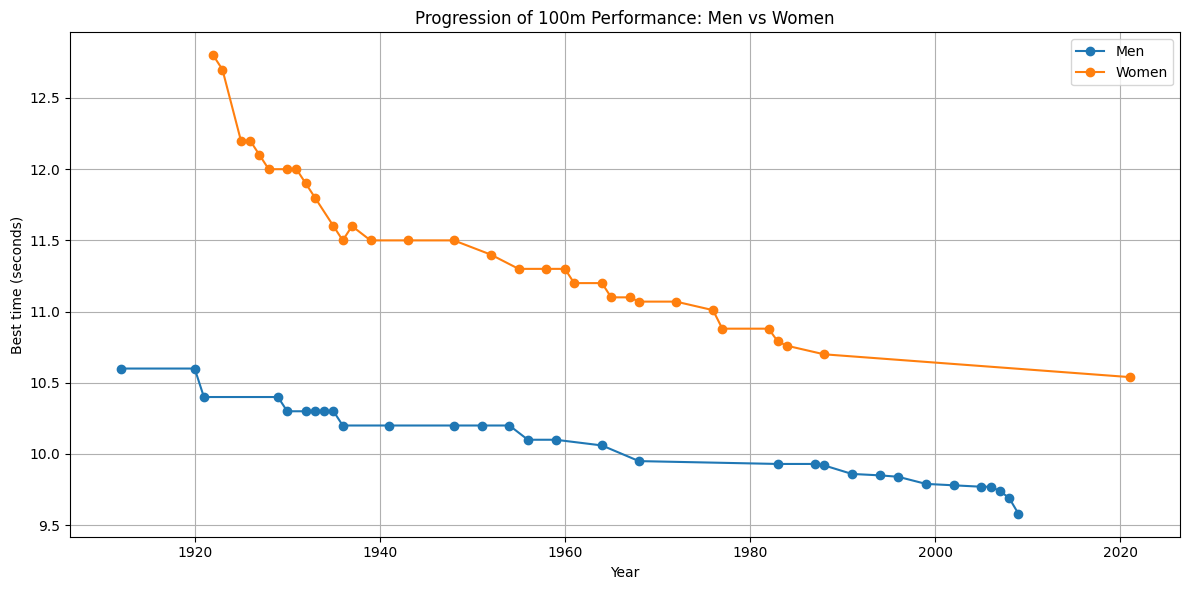

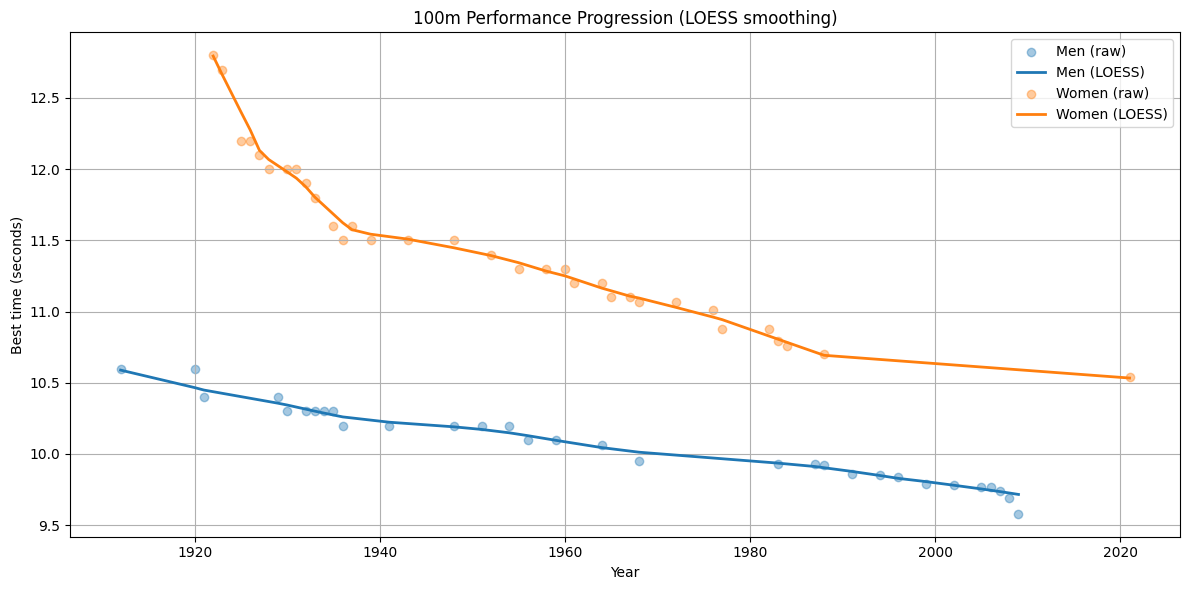

sex,men,women
year,,
1912,10.6,NaN
1913,10.6,NaN
1914,10.6,NaN
1915,10.6,NaN
1916,10.6,NaN


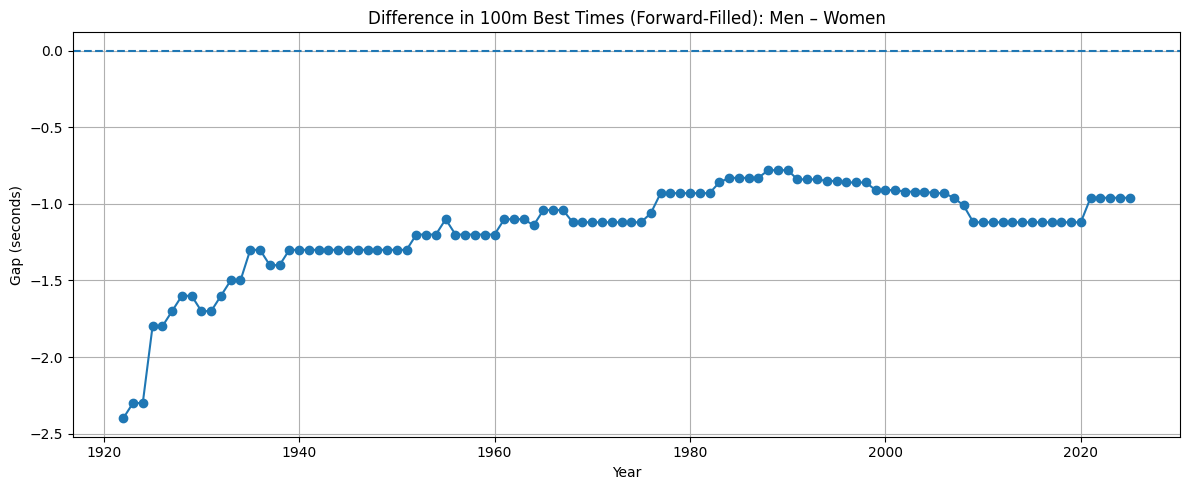

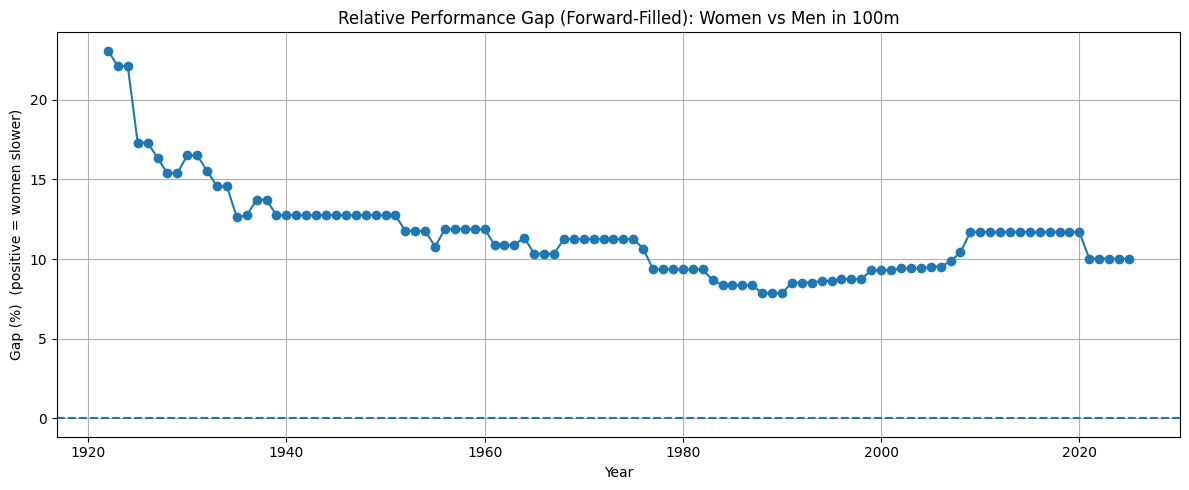


Regression slopes on yearly best times:
  Men slope: -0.0083 seconds per year
  Women slope: -0.0215 seconds per year


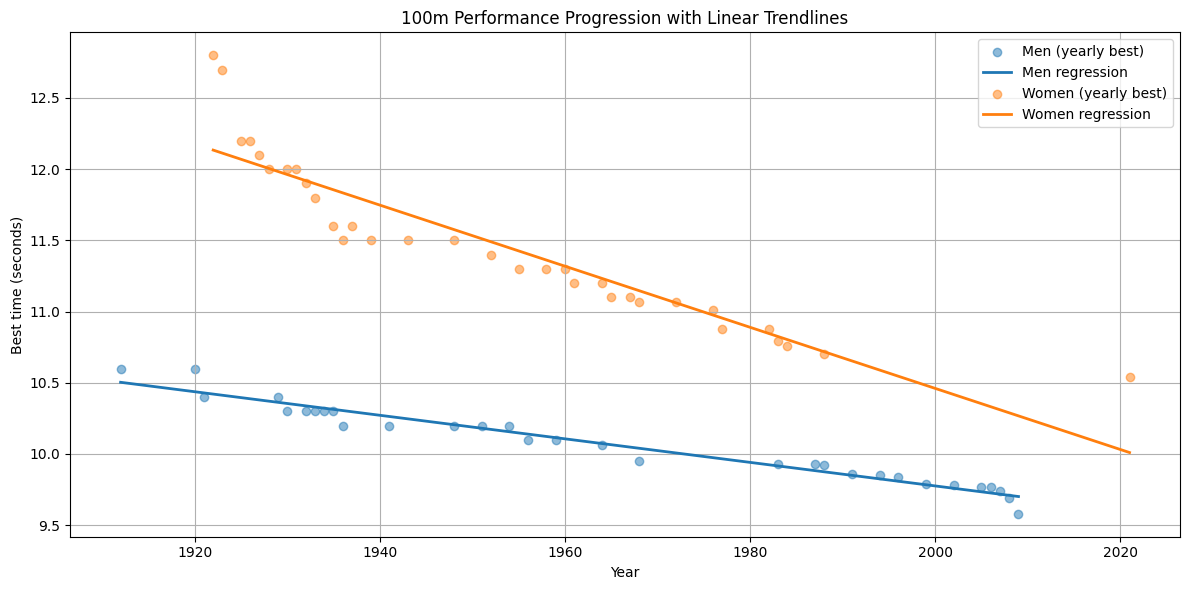


Regression slopes on forward-filled series:
  Men regression slope: -0.00875 seconds/year
  Women regression slope: -0.01575 seconds/year


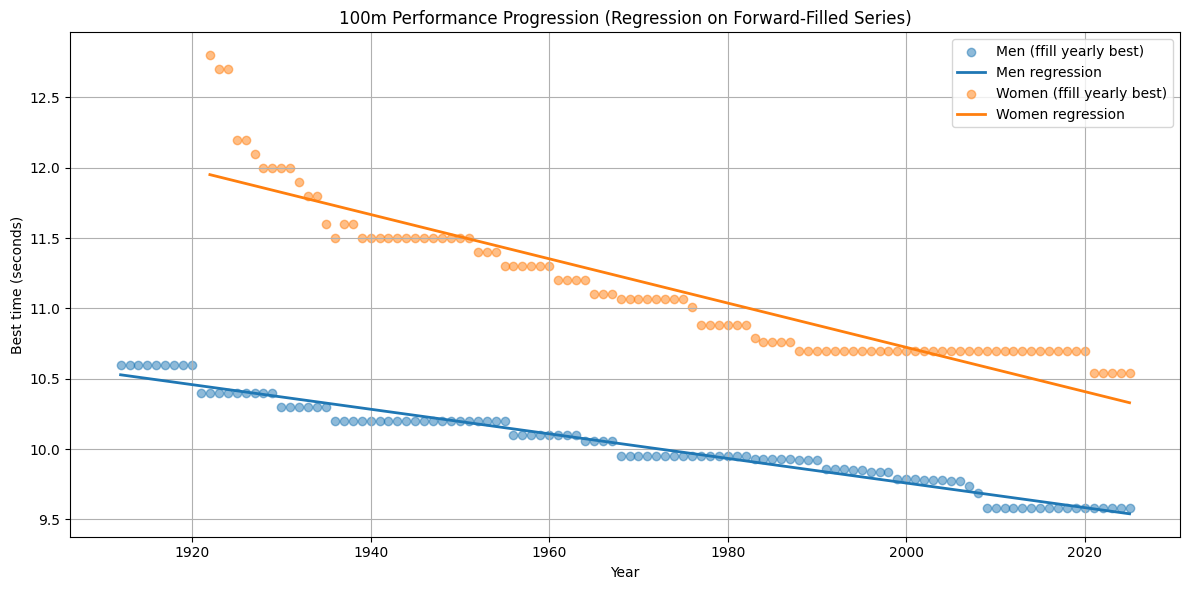


===== Event: 200m | Sexes: ['men', 'women'] =====


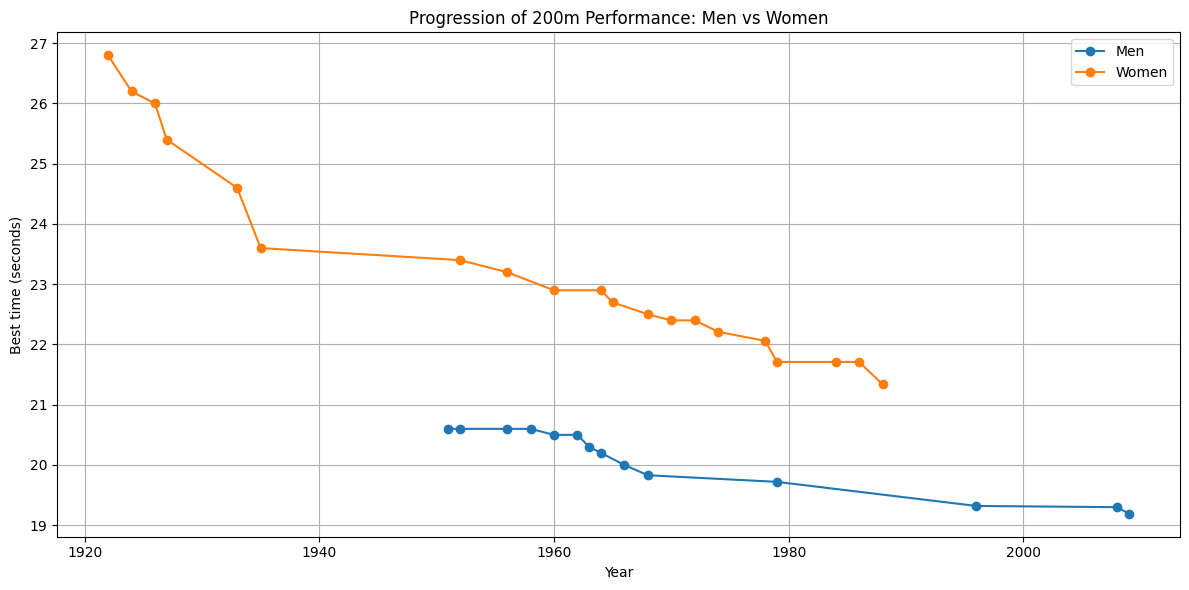

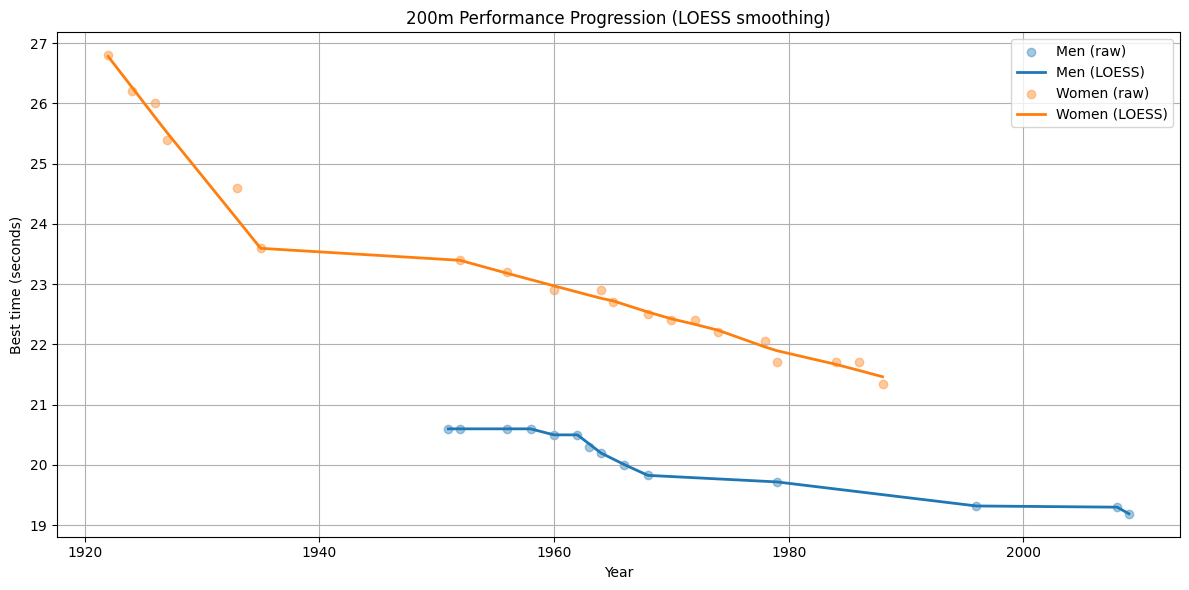

sex,men,women
year,,
1922,NaN,26.8
1923,NaN,26.8
1924,NaN,26.2
1925,NaN,26.2
1926,NaN,26.0


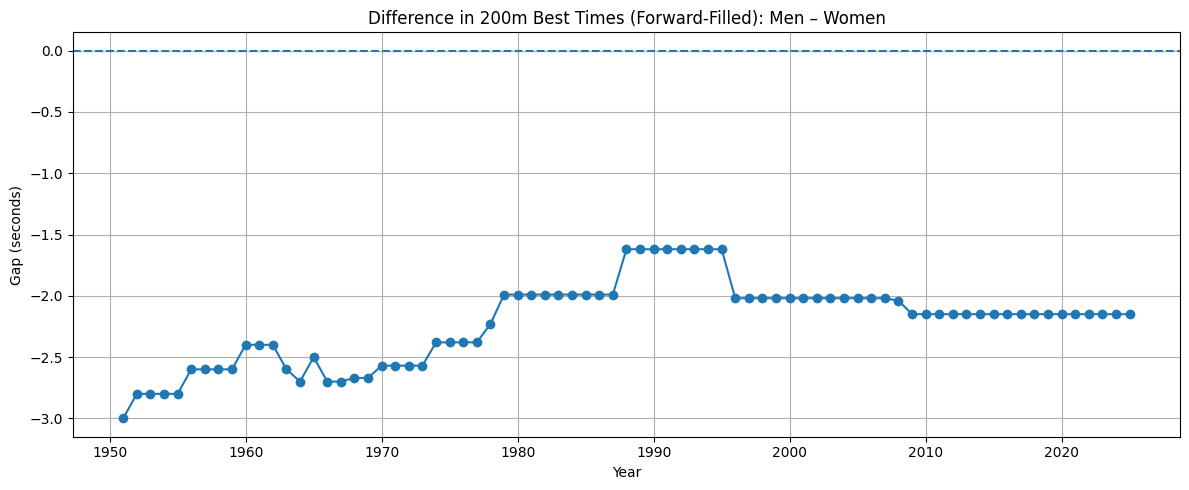

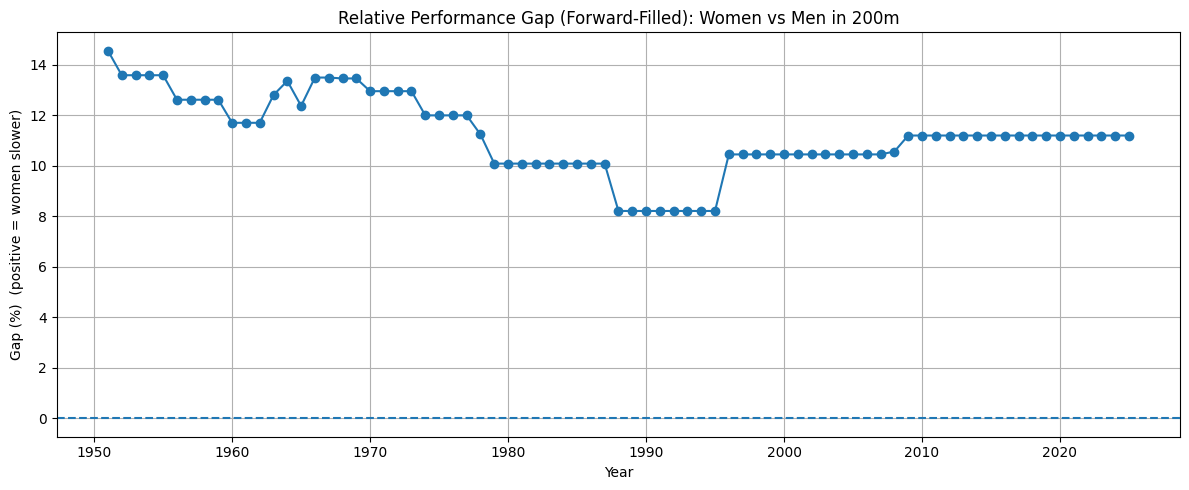


Regression slopes on yearly best times:
  Men slope: -0.0258 seconds per year
  Women slope: -0.0702 seconds per year


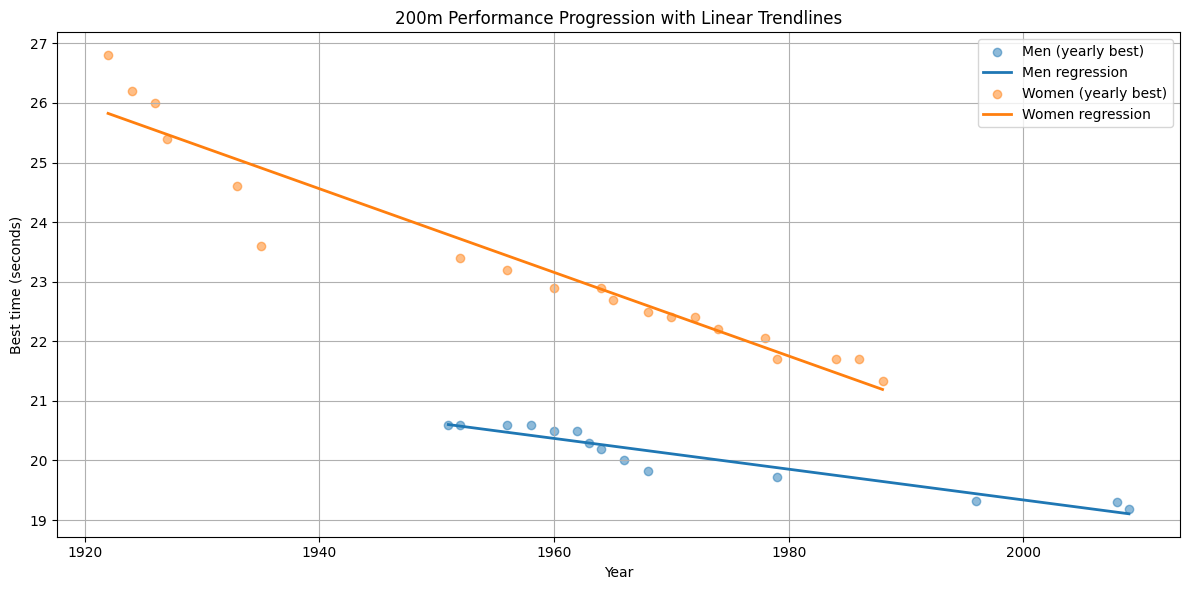


Regression slopes on forward-filled series:
  Men regression slope: -0.02066 seconds/year
  Women regression slope: -0.04418 seconds/year


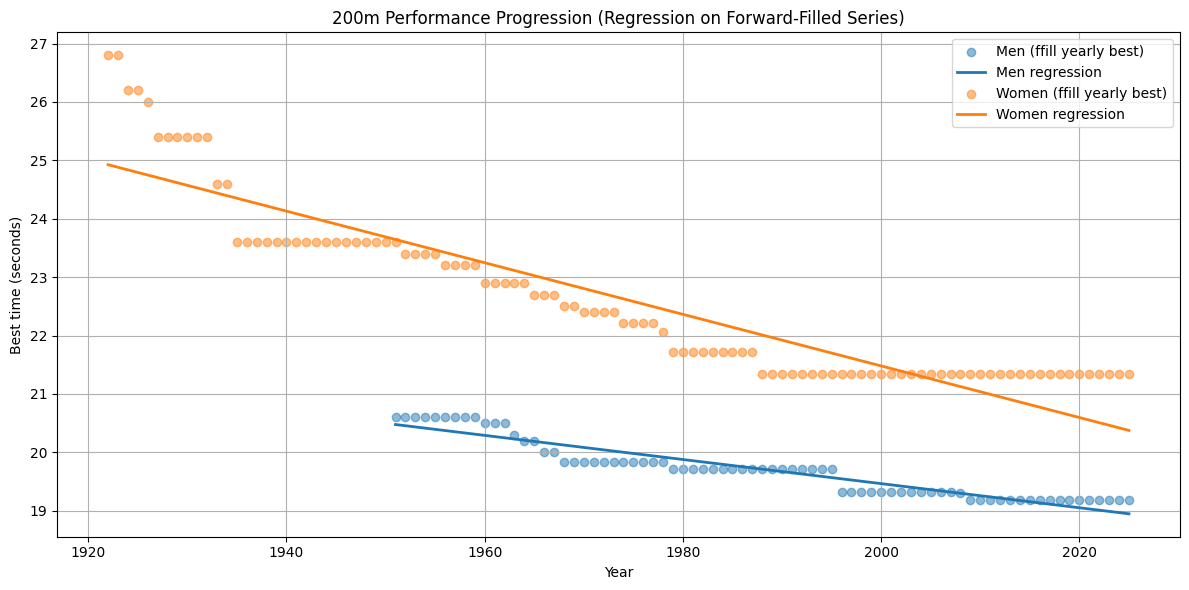

In [10]:
# Loop over all unique events and plot
events = sorted(df["event"].unique())
print("Events found:", events)

for ev in events:
    plot_event_progression(df, ev, end_year=2025)


### OLD CODE

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

# Project root = parent directory of notebooks/
PROJECT_ROOT = Path().resolve().parent

# Data directories
DATA_RAW = PROJECT_ROOT / "data" / "raw"
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"

# Prepare data for plotting
df = pd.read_csv(DATA_PROCESSED / "100m_results_clean.csv", parse_dates=["date"])
df["time_seconds"] = pd.to_numeric(df["time_seconds"], errors="coerce")
df = df.dropna(subset=["time_seconds", "sex", "date"])

# Create a 'year' column
df["year"] = df["date"].dt.year


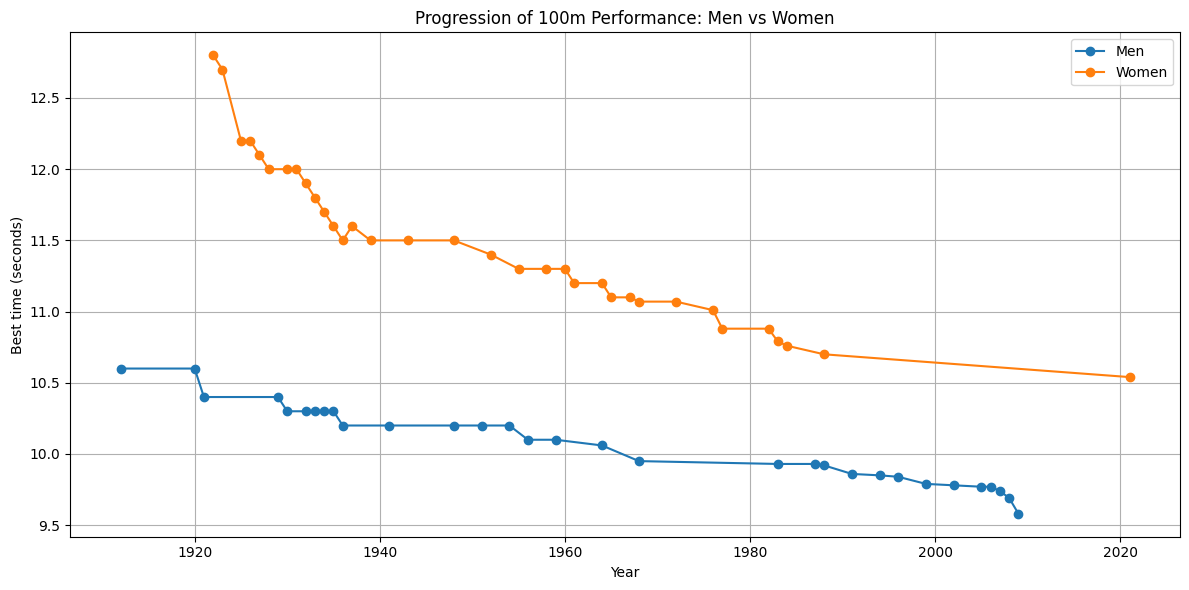

In [2]:
import matplotlib.pyplot as plt

# Compute yearly best time (minimum) for each sex
yearly_best = (
    df.groupby(["sex", "year"])["time_seconds"]
      .min()
      .reset_index()
)

# Plot
plt.figure(figsize=(12, 6))
for sex, group in yearly_best.groupby("sex"):
    plt.plot(group["year"], group["time_seconds"], marker="o", label=sex.capitalize())

plt.title("Progression of 100m Performance: Men vs Women")
plt.xlabel("Year")
plt.ylabel("Best time (seconds)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

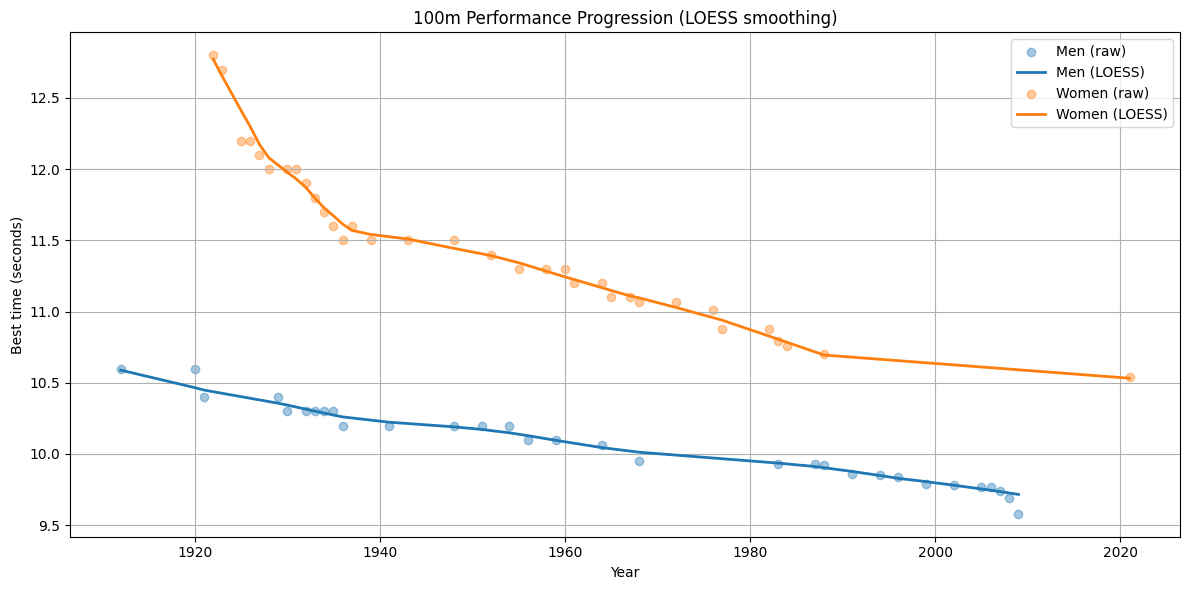

In [3]:
from statsmodels.nonparametric.smoothers_lowess import lowess

plt.figure(figsize=(12, 6))

for sex, group in yearly_best.groupby("sex"):
    group = group.sort_values("year")

    # Raw points
    plt.scatter(group["year"], group["time_seconds"], alpha=0.4, label=f"{sex.capitalize()} (raw)")

    # LOESS smoothing
    smoothed = lowess(
        endog=group["time_seconds"],
        exog=group["year"],
        frac=0.3  # smoothing parameter (0.2–0.4 usually looks good)
    )
    plt.plot(smoothed[:, 0], smoothed[:, 1], linewidth=2, label=f"{sex.capitalize()} (LOESS)")

plt.title("100m Performance Progression (LOESS smoothing)")
plt.xlabel("Year")
plt.ylabel("Best time (seconds)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [4]:
### Build a continuous yearly series and forward-fill

# Determine the full range of years
start_year = int(yearly_best["year"].min())
end_year = 2025  # current year

years = pd.Index(range(start_year, end_year + 1), name="year")

# Pivot: year as index, one column per sex
pivot = (
    yearly_best
    .pivot(index="year", columns="sex", values="time_seconds")
    .reindex(years)          # ensure all years are present
    .sort_index()
)

# Forward-fill each sex separately: propagate last known record
pivot = pivot.ffill()

display(pivot)


sex,men,women
year,,
1912,10.60,NaN
1913,10.60,NaN
1914,10.60,NaN
1915,10.60,NaN
1916,10.60,NaN
...,...,...
2021,9.58,10.54
2022,9.58,10.54
2023,9.58,10.54
